# Ising model

The aim of this exercise is to meet the glorious ising model, and torealize that the direct sampling of the probability distribution is useless in this case.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## 1 - Taking confidence with the 2-d standard Ising model

In the 2-d standard Ising model, the nodes are arranged in a two dimensional lattice, let's say of size $L$. Therefore, the total number of spins is $N=L^2$. Each spin is identified by its coordinates $(x,y)$, where $x, y \in \lbrace 1,2, \ldots, L\rbrace$.

The interactions occur only between nearest neighbours of the lattice with a constant coupling coefficient $J$: the spin at $(x,y)$ interact with $(x+1,y)$, $(x-1,y)$, $(x,y+1)$, $(x,y-1)$. We also impose periodic boundary conditions, such that the spin at the boundary $(L, y)$ interact with the spin at the opposite boundary $(0,y)$ (the same is true for the spins at $y=L$ and $y=0$).
As a consequence, the Hamiltonian of the system has this shape:

\begin{equation}
\mathcal{H}\left(\vec{\sigma}\right) = - \sum_{x,y = 1}^{L} \sigma_{x,y} \left[ \frac{J}{2}  \left( \sigma_{x+1,y} + \sigma_{x-1,y} + \sigma_{x,y+1} + \sigma_{x,y-1} \right) + h \right]
\end{equation}

where the spins are binary variables, $\sigma_{x,y} \in \lbrace -1,1 \rbrace$, and the boundary conditions say that $x,y=L+1 = 1$ and $x,y=L=0$.

### 1a - Generate a random state of spins, compute its energy, and magnetization.

First, write a function that generate a random configuration/state, taking as argument the side of the lattice $L$.
This function returns the configuration as a numpy matrix.

In [ ]:
def rand_state(L):
  return np.random.randint(0, 2, (L,L))*2-1

In [ ]:
rand_state(4)


array([[-1,  1, -1,  1],
       [ 1,  1,  1, -1],
       [ 1,  1, -1, -1],
       [ 1,  1,  1,  1]])

Second, write the function that compute the energy of a given configuration. This function takes as arguments the configuration, the coupling constant $J$ and the external field $h$.

Be careful about the boundary conditions!

In [ ]:
def energy(state, coupling_const, ext_field):
  energy = 0
  lx, ly = state.shape
  for i_pair, s in np.ndenumerate(state):
    nb_energy = 0
    nb_energy += state[(i_pair[0], (i_pair[1]+1)%ly)]
    nb_energy += state[(i_pair[0], (i_pair[1]-1)%ly)]
    nb_energy += state[((i_pair[0]+1)%lx, i_pair[1])]
    nb_energy += state[((i_pair[0]-1)%lx, i_pair[1])]
    energy -= s * (coupling_const * nb_energy / 2 + ext_field)
  return energy

Third, write the function that compute the magnetization taking the configuration as argument.
$$
M(\vec{\sigma}) = \frac{1}{L^2} \sum_{x,y=1}^L \sigma_{x,y}
$$

In [ ]:
def magnetization(state):
  lx, ly = state.shape
  return state.sum() / lx / ly

Now you can try to fix the parameters $L$, $J$ and $h$, generate a random configuration and compute its energy and magnetization.

In [ ]:
L = 10
J = 1
h = 1

rand_state = rand_state(L)

print('Energy of the state at J={} and h={}: {}'.format(J, h, energy(rand_state, J, h)))
print('Magnetization of the state: {}'.format(magnetization(rand_state)))

Energy of the state at J=1 and h=1: 24
Magnetization of the state: 0.0


### 1b - Try to do the same with a configuration having all the spins up.

In [ ]:
state = np.ones((L,L))

print('Energy of the state at J={} and h={}: {}'.format(J, h, energy(state, J, h)))
print('Magnetization of the state: {}'.format(magnetization(state)))

Energy of the state at J=1 and h=1: -500.0
Magnetization of the state: 1.0


### 1c - Plot the configuration that you have generated.

For doing a "color map" in which the values stored in a matrix are plotted with different colors depending on their value (excatly our case), you can use plt.imshow as below.

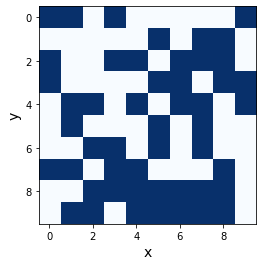

In [ ]:
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.imshow(rand_state, cmap='Blues')

## 2 - Compute the partition function of the system and realize that direct sampling is impossible

The equilibrium distribution of a canonical ensemble is given by the Gibbs measure:

\begin{equation}
\pi\left( \vec{\sigma} \right) = \frac{1}{Z(\beta)} e^{-\beta \; \mathcal{H}\left( \vec{\sigma} \right)  }
\end{equation}

where $\beta$ is proportional to the inverse of the temperature, and the normalization constant is the partition function of the system:

\begin{equation}
Z(\beta) = \sum_{\vec{\sigma}} e^{-\beta \; \mathcal{H}\left( \vec{\sigma} \right)  }
\end{equation}

Note that to compute the partition function, one has to enumerate all the states of the system $\vec{\sigma}$, which, in our case, are all the possible combinations of $+1$ and $-1$ of for all the $N$ spins, therefore $2^N$ states.
The fact that the number of states exponentially increase with $N$ is basically the reason why it is not possible to manage the model simulation by directly sampling the probability distribution $\pi\left( \vec{\sigma} \right)$.


### 2a - Write a function that returns the non-normalized Gibbs weight of a given configuration. 

It takes as arguments the configuration, $\beta$, $J$, and $h$. (Use the energy function that you have written before).

In [ ]:
def gibbs_weight(state, beta, coupling_const, ext_field):
  return np.exp(- beta * energy(state, coupling_const, ext_field))

Compute the partition function. To do this you have to enumerate all the possible configurations, and compute the Gibbs measure for each of them. For the enumeration use the use the suggested iterable written below.


In [ ]:
from itertools import product

def partition_function(L, beta, coupling_const, ext_field):
  Z = 0
  for i in product([-1,1], repeat=L**2):
    state = np.array(i).reshape((L,L))
    Z += gibbs_weight(state, beta, coupling_const, ext_field)
  return Z

print(partition_function(4, 1, 1/16, 1))

1111153484.9293277


You cannot enumerate all the states even for a very small system, e.g. $L > 6$. This makes impossible to compute the average of observables (e.g. the magnetization) using the analytical summation, as well as to extract samples form the probability distribution using direct Montecarlo methods.


In [ ]:

def energy_autocorrelation(q, L, beta, coupling_const, ext_field, burn_in_time, max_time, n_realizations):
    """This computes the temporal autocorrelation from "burn_in_time" for "max_time" of the average energy over "n_realizations".
    having side L, "beta", "J" and "h". 
    Args:
        L(int): number of rows/columns of the matrix(sites)
        q(int): how many colors in a state
        beta(float): beta (inverse temperature)
        coupling_const(float): coupling constant
        ext_field(float): external magnetic field
        burn_in_time(int): the number of samples that correspond to the transient time (that needs to be discarded)
        max_time(int): the number of iterations
        n_realizations(int): the number of realziations       
        
    Returns:
        rho(float): autocorrelation"""

    # Init the energy product, the first and the second moments
    prod = np.zeros(max_time)
    average_at_start = 0
    average_at_next = np.zeros(max_time)
    sec_moment_at_start = 0
    sec_moment_at_next = np.zeros(max_time)

    for i in range(n_realizations):

        # Equilibration
        state = state_generator(q, L)
        for j in range(burn_in_time):
            state = metropolis_step(state, q, coupling_const, ext_field, beta)

        # The start value of the energy is computed after the burn-in period.
        start_energy = energy(state, coupling_const, ext_field)
        average_at_start += start_energy / n_realizations
        sec_moment_at_start += start_energy * start_energy / n_realizations

        # Storing the value of all the energy after the burn-in
        traj = np.array([])
        for k in range(burn_in_time, burn_in_time + max_time):
            state = metropolis_step(state, q, coupling_const, ext_field, beta)
            traj = np.append(traj, energy(state, coupling_const, ext_field))
        # Computing the statistical variables 
        prod += start_energy * traj / n_realizations
        average_at_next += traj / n_realizations
        sec_moment_at_next += traj*traj / n_realizations

    std_start = np.sqrt(sec_moment_at_start - average_at_start**2)
    std_next = np.sqrt(sec_moment_at_next - average_at_next**2)
    return (prod - average_at_next*average_at_start) / std_start / std_next